In [1]:
pip install tfds-nightly

     |████████████████████████████████| 3.6MB 9.4MB/s 


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tqdm import trange

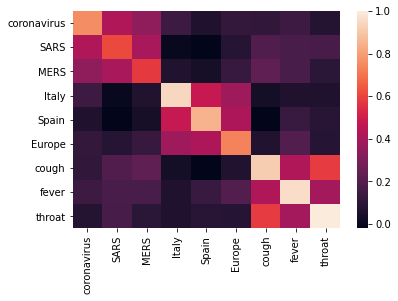

In [3]:
def plot_correlation(labels, features):
  corr = np.inner(features,features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

queries = [
             "coronavirus","SARS","MERS",
             "Italy","Spain","Europe",
             "cough", "fever", "throat"
  ]
 
module = hub.load("https://tfhub.dev/tensorflow/cord-19/swivel-128d/3")
embeddings = module(queries)
plot_correlation(queries,embeddings)

In [4]:
builder = tfds.builder(name="scicite")
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split = ("train","validation","test"),
    as_supervised = True
)

Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incomplete58XW16/scicite-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incomplete58XW16/scicite-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incomplete58XW16/scicite-test.tfrecord


Dataset scicite downloaded and prepared to /root/tensorflow_datasets/scicite/1.0.0. Subsequent calls will reuse this data.


In [5]:
NUM_EXAMPLES = 12
TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def labeltostr(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]


data = next(iter(train_data.batch(NUM_EXAMPLES)))
pd.DataFrame({
    TEXT_FEATURE_NAME : [ex.numpy().decode("utf8") for ex in data[0]],
    LABEL_NAME : [labeltostr(x) for x in data[1]]
})  

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


In [6]:
EMBEDDING = "https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"
TRAINABLE_MODULE = False
hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[],
                           dtype=tf.string,trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)

model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               17301632  
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 17,302,019
Trainable params: 17,302,019
Non-trainable params: 0
_________________________________________________________________


In [7]:
EPOCHS = 35
BATCH_SIZE = 32
history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35
257/257 [==============================] - 7s 26ms/step - loss: 1.3429 - accuracy: 0.4033 - val_loss: 1.0974 - val_accuracy: 0.4640
Epoch 2/35
257/257 [==============================] - 7s 26ms/step - loss: 1.1016 - accuracy: 0.4769 - val_loss: 1.0986 - val_accuracy: 0.4924
Epoch 3/35
257/257 [==============================] - 7s 26ms/step - loss: 1.0967 - accuracy: 0.4830 - val_loss: 1.0986 - val_accuracy: 0.4945
Epoch 4/35
257/257 [==============================] - 6s 25ms/step - loss: 1.0967 - accuracy: 0.4862 - val_loss: 1.0986 - val_accuracy: 0.4956
Epoch 5/35
257/257 [==============================] - 6s 25ms/step - loss: 1.0966 - accuracy: 0.4874 - val_loss: 1.0986 - val_accuracy: 0.4967
Epoch 6/35
257/257 [==============================] - 6s 25ms/step - loss: 1.0966 - accuracy: 0.4880 - val_loss: 1.0986 - val_accuracy: 0.4967
Epoch 7/35
257/257 [==============================] - 6s 25ms/step - loss: 1.0966 - accuracy: 0.4880 - val_loss: 1.0986 - val_accuracy: 0.4967

In [8]:
def display_training_curves(training,validation,title,subplot):
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor="#F0F0F0")
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor("#F8F8F8")
  ax.plot(training)
  ax.plot(validation)
  ax.set_title("model" + title)
  ax.set_ylabel(title)
  ax.set_xlabel("epoch")
  ax.legend(["train","valid."])


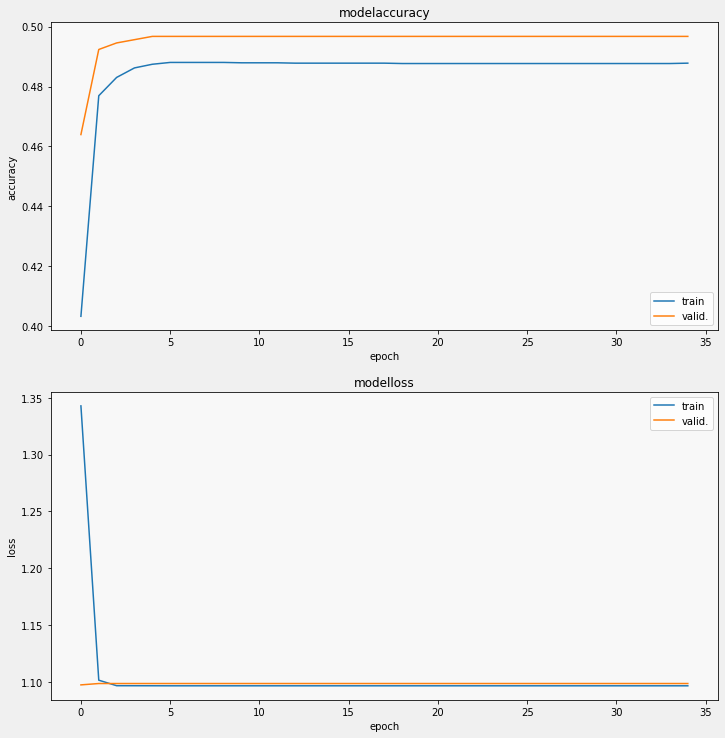

In [9]:
display_training_curves(history.history["accuracy"], history.history["val_accuracy"],"accuracy",211)
display_training_curves(history.history["loss"], history.history["val_loss"],"loss",212)

In [11]:
results = model.evaluate(test_data.batch(512),verbose=2)

for name,value in zip(model.metrics_names,results):
  print("%s: %.3f" % (name,value))

4/4 - 0s - loss: 1.1302 - accuracy: 0.4276
loss: 1.130
accuracy: 0.428


In [12]:
pred_dataset = next(iter(test_data.batch(20)))
pred_texts = [ex.numpy().decode("utf8") for ex in pred_dataset[0]]
pred_labels = [labeltostr(x) for x in pred_dataset[1]]

predictions = [labeltostr(x) for x in model.predict_classes(pred_texts)]

pd.DataFrame({
    TEXT_FEATURE_NAME : pred_texts,
    LABEL_NAME : pred_labels,
    "predictions": predictions
})  

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,string,label,predictions
0,"The diffraction grating, LED, and split detect...",background,background
1,Our ideas are based on a previous paper [4] de...,background,background
2,Our finding is consistent with the literature ...,result,background
3,Test scores from each of the cognitive domains...,method,background
4,The optimization algorithm was set to maximize...,method,result
5,To quantify the extent of substitution saturat...,method,background
6,Examples of gesture control are based on the e...,method,background
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background


In [ ]:
data = next(iter(train_data.batch(NUM_EXAMPLES)))
pd.DataFrame({
    TEXT_FEATURE_NAME : [ex.numpy().decode("utf8") for ex in data[0]],
    LABEL_NAME : [labeltostr(x) for x in data[1]]
})  